<a href="https://colab.research.google.com/github/tmckim/materials-fa23-colab-working/blob/main/lectures/lec05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Before you start - Save this notebook!

When you open a new Colab notebook from the WebCampus (like you hopefully did for this one), you cannot save changes. So it's  best to store the Colab notebook in your personal drive `"File > Save a copy in drive..."` **before** you do anything else.

The file will open in a new tab in your web browser, and it is automatically named something like: "**Copy of lec05.ipynb**". You can rename this to just the title of the assignment "**lec05.ipynb**". Make sure you do keep an informative name (like the name of the assignment) so that you know which files to submit back to WebCampus for grading! More instructions on this are at the end of the notebook.


**Where does the notebook get saved in Google Drive?**

By default, the notebook will be copied to a folder called “Colab Notebooks” at the root (home directory) of your Google Drive. If you use this for other courses or personal code notebooks, I recommend creating a folder for this course and then moving the assignments AFTER you have completed them.

In [ ]:
# Setup and add files needed to gdrive
# If you restart colab, start by rerunning this cell first!
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

#!mkdir -p '/content/gdrive/My Drive/colab-materials-NS499DataSci-notebooks/'
%cd /content/gdrive/My Drive/colab-materials-NS499DataSci-notebooks/
!rm -r materials-fa23-colab-working

!git clone https://github.com/tmckim/materials-fa23-colab-working '/content/gdrive/My Drive/colab-materials-NS499DataSci-notebooks/materials-fa23-colab-working/'

%cd /content/gdrive/MyDrive/colab-materials-NS499DataSci-notebooks/materials-fa23-colab-working/lectures/

In [ ]:
############### TEST
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

%cd /content/gdrive/MyDrive/colab-materials-NS499DataSci-notebooks/materials-fa23-colab-working/lectures/

Mounted at /content/gdrive
/content/gdrive/MyDrive/colab-materials-NS499DataSci-notebooks/materials-fa23-colab-working/lectures


In [ ]:
# Import packages and other things needed
# Don't change this cell; Just run this cell
# If you restart colab, make sure to run this cell again after the first one above^

from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action='ignore',category=np.VisibleDeprecationWarning)

## Lecture 05 ##

Topics:
- Reviewing functions
- Working with apply and group
- Introduce Python lists
- Show how to build tables from rows instead of columns
- Introduce pivots - a special kind of grouping
- Introduce joins

## Prediction ##

Can we predict how tall a child will grow based on the height of their parents?

To do this we will use the famous [Galton's height dataset](https://galton.org/essays/1880-1889/galton-1886-jaigi-regression-stature.pdf) that was collected to demonstrate the connection between parent's heights and the height of their children.


In [ ]:
# Read in the table of data
families = Table.read_table('family_heights.csv')
families

family,father,mother,child,children,order,sex
1,78.5,67,73.2,4,1,male
1,78.5,67,69.2,4,2,female
1,78.5,67,69,4,3,female
1,78.5,67,69,4,4,female
2,75.5,66.5,73.5,4,1,male
2,75.5,66.5,72.5,4,2,male
2,75.5,66.5,65.5,4,3,female
2,75.5,66.5,65.5,4,4,female
3,75,64,71,2,1,male
3,75,64,68,2,2,female


## Exploring the Data ##

**Exercise**: Add a column `parent average` containing the average height of both parents.

In [ ]:
families = families.with_columns(
    'parent average', (families.column('father') + families.column('mother'))/2)
families

family,father,mother,child,children,order,sex,parent average
1,78.5,67,73.2,4,1,male,72.75
1,78.5,67,69.2,4,2,female,72.75
1,78.5,67,69,4,3,female,72.75
1,78.5,67,69,4,4,female,72.75
2,75.5,66.5,73.5,4,1,male,71
2,75.5,66.5,72.5,4,2,male,71
2,75.5,66.5,65.5,4,3,female,71
2,75.5,66.5,65.5,4,4,female,71
3,75,64,71,2,1,male,69.5
3,75,64,68,2,2,female,69.5


What is the relationship between a child's height and the average parent's height?

**Exercise**: make a scatterplot showing the relationship between `parent average` and the `child` height

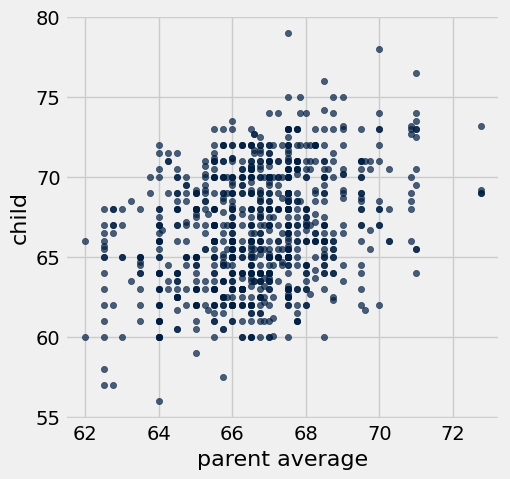

In [ ]:
# Scatterplot
families.scatter('parent average', 'child')

Questions:
1. Do we observe a relationship between child and parent height?
2. Would a line plot help reveal that relationship?

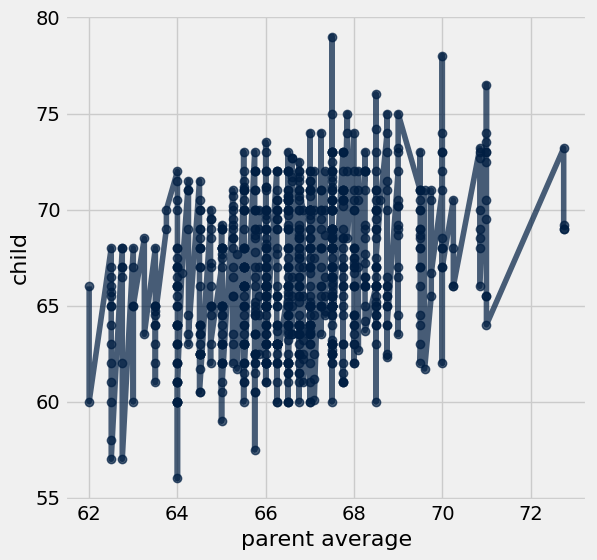

In [ ]:
# How do we draw a line plot?
families.plot('parent average', 'child', marker = 'o')

## Making a Prediction ##

If we wanted to predict the height of a child given the height of the parents, we could look at the height of children with parents who have a similar average height.

In [ ]:
# Example parent height values
parent1_height = 5*12 + 10 # 5 ft 10 inches
parent2_height = 5*12+7 # 5 ft 7 inches

In [ ]:
# Calc parent average
calc_parent_avg = (parent1_height + parent2_height)/2
calc_parent_avg

68.5

Let's look at parents that are within 1 inch of our height

In [ ]:
window = 1
lower_bound = calc_parent_avg - window
upper_bound = calc_parent_avg + window

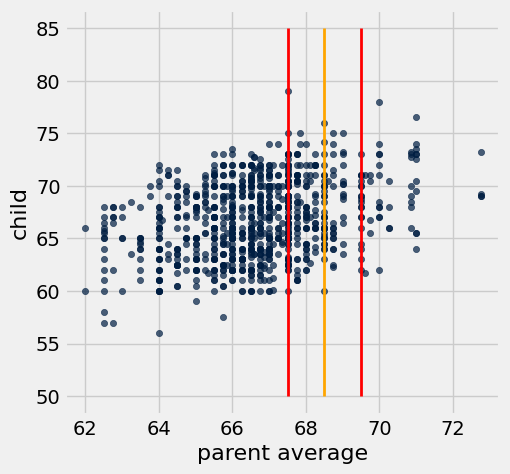

In [ ]:
# Scatterplot
families.scatter('parent average', 'child')
# you don't need to know the details of this plotting code yet
plots.plot([lower_bound, lower_bound], [50, 85], color='red', lw=2)
plots.plot([calc_parent_avg, calc_parent_avg], [50, 85], color='orange', lw=2);
plots.plot([upper_bound, upper_bound], [50, 85], color='red', lw=2);

**Exercise**: Create a function that takes an average of the parent heights and returns ***an array of all the children's heights*** that are within the window of the parent's average height.

In [ ]:
def similar_child_heights(parent_average):
    lower_bound = parent_average - window
    upper_bound = parent_average + window
    return (
        families
        .where("parent average", are.between(lower_bound, upper_bound))
        .column("child")
    )

Test the function:

In [ ]:
# window = 1.0 originally
# window = 5.0 # smaller or larger- what happens?
similar_child_heights(calc_parent_avg)

array([ 74. ,  70. ,  68. ,  67. ,  67. ,  66. ,  63.5,  63. ,  74. ,
        73. ,  71.5,  62.5,  66.5,  62.3,  66. ,  64.5,  64. ,  62.7,
        74.2,  70.5,  69.5,  66. ,  65.5,  65. ,  65. ,  65.5,  66. ,
        63. ,  67.5,  67.2,  66.7,  70. ,  67. ,  67. ,  66.5,  70. ,
        69. ,  68.5,  66. ,  64.5,  63. ,  71. ,  67. ,  76. ,  72. ,
        71. ,  66. ,  66. ,  70.5,  72. ,  72. ,  71. ,  69. ,  66. ,
        65. ,  73. ,  65.2,  68.5,  67.7,  68. ,  68. ,  62. ,  72. ,
        71. ,  70.5,  67. ,  72. ,  71. ,  70. ,  66. ,  64.5,  64.5,
        62. ,  70. ,  69. ,  66. ,  64. ,  60. ,  67.5,  73. ,  72. ,
        72. ,  66.5,  69.2,  67.2,  66.5,  66. ,  66. ,  64.2,  63.7,
        75. ,  71. ,  70. ,  66. ,  66. ,  65.5,  65. ,  65. ,  64. ,
        64. ,  64. ,  70.5,  67.5,  64.5,  64. ])

**Exercise**: Create a function to predict the child's height as the average of the height of children within the window of the average parent height.

In [ ]:
# Create a new function that uses our previous function
def predict_child_height(parent_average):
    return np.average(similar_child_heights(parent_average))

In [ ]:
# Test the function to get our mean
predict_child_height(calc_parent_avg)

67.531428571428577

Let's plot the predicted height as well as the distribution of children's heights:

Mean: 67.5314285714


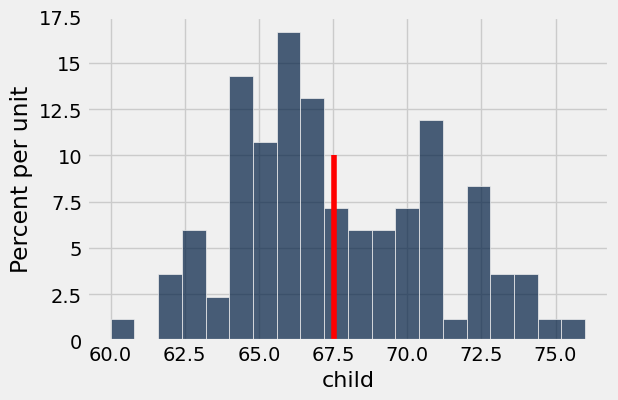

In [ ]:
# window = 1.0
similar = similar_child_heights(calc_parent_avg) # array of heights from our first function
predicted_height = predict_child_height(calc_parent_avg) # single # for the average from our second function

print("Mean:", predicted_height)
Table().with_column("child", similar).hist("child", bins= 20) # new table with the values in the array to plot with hist
plots.plot([predicted_height, predicted_height], [0,0.1], color = "red") # added a line for the average that we calculated

## Prediction Accuracy: Evaluating the Predictions ##

To evalute the predictions, let's see how the predictions compare to the actual heights of all the children in our dataset.

**Exercise**: Apply the function (using `appy`) to all the parent averages in the table and save the result to the `predicted` column.

In [ ]:
# window = 1.0
families = families.with_column(
    "predicted", families.apply(predict_child_height, "parent average")
)
families

family,father,mother,child,children,order,sex,parent average,predicted
1,78.5,67,73.2,4,1,male,72.75,70.1
1,78.5,67,69.2,4,2,female,72.75,70.1
1,78.5,67,69,4,3,female,72.75,70.1
1,78.5,67,69,4,4,female,72.75,70.1
2,75.5,66.5,73.5,4,1,male,71,70.4158
2,75.5,66.5,72.5,4,2,male,71,70.4158
2,75.5,66.5,65.5,4,3,female,71,70.4158
2,75.5,66.5,65.5,4,4,female,71,70.4158
3,75,64,71,2,1,male,69.5,68.5025
3,75,64,68,2,2,female,69.5,68.5025


**Exercise**: Construct a scatterplot with the `parent average` height on the x-axis and the `child` height and the `predicted` height on the y-axis.

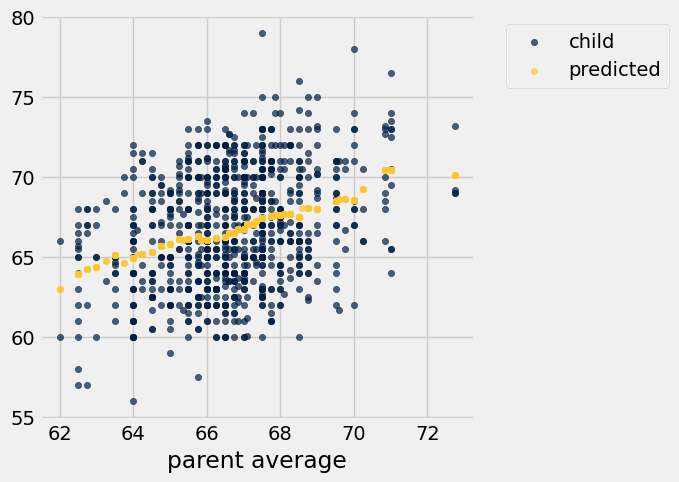

In [ ]:
families.select("parent average", "child", "predicted").scatter("parent average")

**Discussion**: What do we see in this plot?

**Exercise**: Define a function to compute the error (the difference) between the predicted value and the true value. Apply that function to the table adding a column containing the `error`. Then construct a histogram of the errors.

In [ ]:
def error(predicted, true_value):
    return predicted - true_value

families = families.with_column(
    "error", families.apply(error, "predicted", "child"))
families

family,father,mother,child,children,order,sex,parent average,predicted,error
1,78.5,67,73.2,4,1,male,72.75,70.1,-3.1
1,78.5,67,69.2,4,2,female,72.75,70.1,0.9
1,78.5,67,69,4,3,female,72.75,70.1,1.1
1,78.5,67,69,4,4,female,72.75,70.1,1.1
2,75.5,66.5,73.5,4,1,male,71,70.4158,-3.08421
2,75.5,66.5,72.5,4,2,male,71,70.4158,-2.08421
2,75.5,66.5,65.5,4,3,female,71,70.4158,4.91579
2,75.5,66.5,65.5,4,4,female,71,70.4158,4.91579
3,75,64,71,2,1,male,69.5,68.5025,-2.4975
3,75,64,68,2,2,female,69.5,68.5025,0.5025


Visualize the distribution of errors:

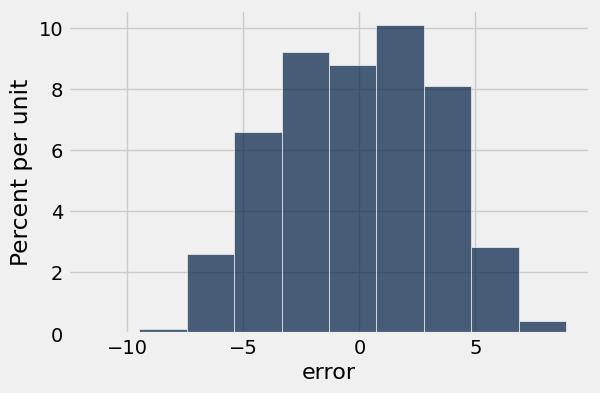

In [ ]:
families.hist('error')

**Exercise**: Overlay the histograms of the error for male and female children.

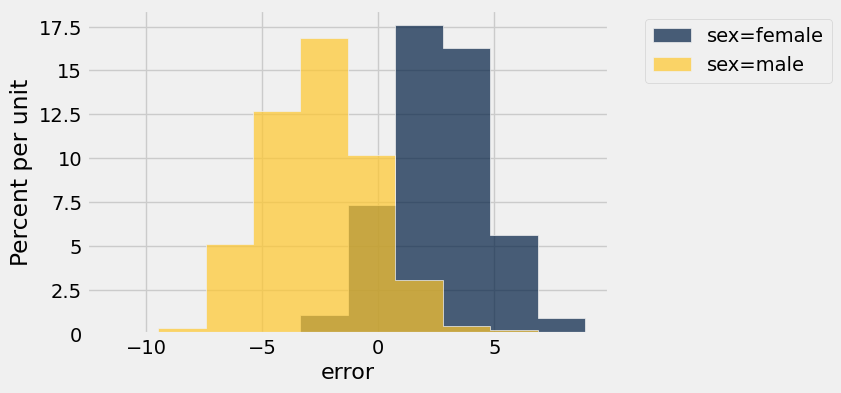

In [ ]:
families.hist('error', group='sex')

**Discussion**: What do we observe?

# Discussion Question: Building a Better Predictor

**Exercise**: Implement a new height prediction function that considers the averages of the height of children with the same sex and whose parents had a similar height.<br><br>

Start by reviewing our previous function:
```
def similar_child_heights(parent_average):
    lower_bound = parent_average - window
    upper_bound = parent_average + window
    return np.average(
        families
        .where("parent average", are.between(lower_bound, upper_bound))
        .column("child")
    )
```



In [ ]:
def predict_child_height_with_sex(parent_average,sex):
    lower_bound = parent_average - window
    upper_bound = parent_average + window
    return np.average(
        families
        .where("sex", sex)
        .where("parent average", are.between(lower_bound, upper_bound))
        .column("child")
    )

In [ ]:
predict_child_height_with_sex(calc_parent_avg, 'female')

65.256666666666661

In [ ]:
predict_child_height_with_sex(calc_parent_avg, 'male')

70.564444444444447

**Exercise**: Apply the better predictor to the table and save the predictions in a column called `predicted with sex`.

In [ ]:
families= families.with_column(
    "predicted with sex", families.apply(predict_child_height_with_sex, "parent average", "sex")
)
families

family,father,mother,child,children,order,sex,parent average,predicted,error,predicted with sex
1,78.5,67,73.2,4,1,male,72.75,70.1,-3.1,73.2
1,78.5,67,69.2,4,2,female,72.75,70.1,0.9,69.0667
1,78.5,67,69,4,3,female,72.75,70.1,1.1,69.0667
1,78.5,67,69,4,4,female,72.75,70.1,1.1,69.0667
2,75.5,66.5,73.5,4,1,male,71,70.4158,-3.08421,73.4889
2,75.5,66.5,72.5,4,2,male,71,70.4158,-2.08421,73.4889
2,75.5,66.5,65.5,4,3,female,71,70.4158,4.91579,67.65
2,75.5,66.5,65.5,4,4,female,71,70.4158,4.91579,67.65
3,75,64,71,2,1,male,69.5,68.5025,-2.4975,70.7955
3,75,64,68,2,2,female,69.5,68.5025,0.5025,65.7


**Exercise**: Construct a histogram of the new errors broke down by the sex of the child.

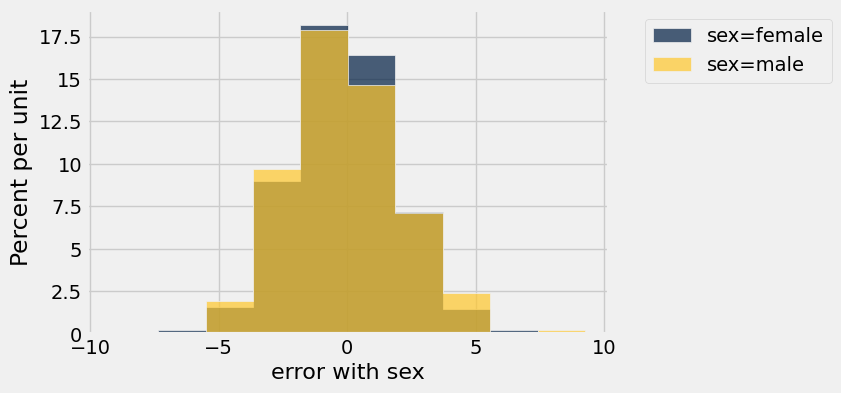

In [ ]:
families = families.with_column(
    "error with sex",  families.apply(error, "predicted with sex", "child")
)
families.hist("error with sex", group="sex")

The previous plot for comparison:

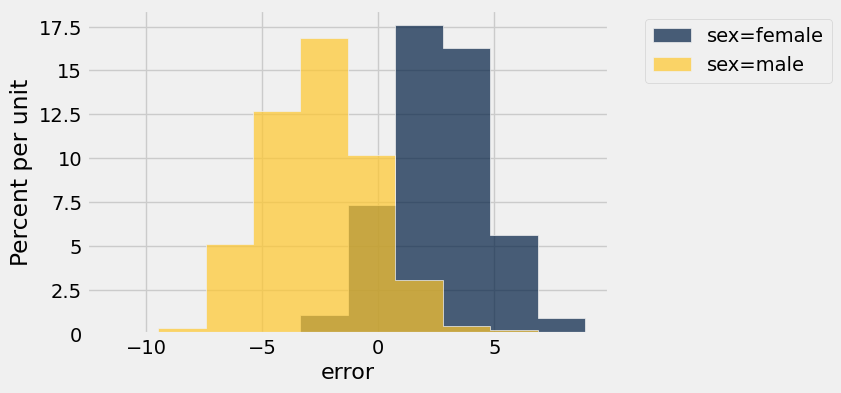

In [ ]:
families.hist("error", group="sex")

## Grouping by One Column ##

In [ ]:
# Load in our ice cream data
cones = Table.read_table('cones_rating.csv')
cones

Flavor,Color,Price,Rating
strawberry,pink,3.55,1
chocolate,light brown,4.75,4
chocolate,dark brown,5.25,3
strawberry,pink,5.25,2
chocolate,dark brown,5.25,5
bubblegum,pink,4.75,1


**Exercise**: use the `group` function to determine the number of cones with each flavor.

In [ ]:
cones.group('Flavor')

Flavor,count
bubblegum,1
chocolate,3
strawberry,2


**Exercise**: Use the `group` function to compute the average price of cones for each flavor.

In [ ]:
cones.group('Flavor', np.average)

Flavor,Color average,Price average,Rating average
bubblegum,,4.75,1
chocolate,,5.08333,4
strawberry,,4.4,1.5


In [ ]:
cones.select('Flavor', 'Price').group('Flavor', np.mean)

Flavor,Price mean
bubblegum,4.75
chocolate,5.08333
strawberry,4.4


**Exercise**: Use the `group` function to compute the minimum price of cones for each flavor.

In [ ]:
cones.group('Flavor', np.min)

Flavor,Color amin,Price amin,Rating amin
bubblegum,,4.75,1
chocolate,,4.75,3
strawberry,,3.55,1


In [ ]:
cones.group('Flavor', min)

Flavor,Color min,Price min,Rating min
bubblegum,pink,4.75,1
chocolate,dark brown,4.75,3
strawberry,pink,3.55,1


In [ ]:
cones

Flavor,Color,Price,Rating
strawberry,pink,3.55,1
chocolate,light brown,4.75,4
chocolate,dark brown,5.25,3
strawberry,pink,5.25,2
chocolate,dark brown,5.25,5
bubblegum,pink,4.75,1


In [ ]:
def my_grp(grp):
    print(grp)
    return grp

cones.group("Flavor", my_grp)

['pink']
['light brown' 'dark brown' 'dark brown']
['pink' 'pink']
[ 4.75]
[ 4.75  5.25  5.25]
[ 3.55  5.25]
[1]
[4 3 5]
[1 2]


Flavor,Color my_grp,Price my_grp,Rating my_grp
bubblegum,['pink'],[ 4.75],[1]
chocolate,['light brown' 'dark brown' 'dark brown'],[ 4.75 5.25 5.25],[4 3 5]
strawberry,['pink' 'pink'],[ 3.55 5.25],[1 2]


## Lists

In [ ]:
# A simple list
[1, 5, 'hello', 5.0]

[1, 5, 'hello', 5.0]

In [ ]:
# Another list
another_list = [1, 5, 'hello', 5.0, make_array(1,2,3)]
another_list

[1, 5, 'hello', 5.0, array([1, 2, 3])]

You have to use square brackets when accessing elements from a list (you can't use `item`)


In [ ]:
another_list[2]

'hello'

In [ ]:
another_list[4][1]

2

Recall that for arrays you could do either. (In the real world, most people would probably use square brackets).

In [ ]:
my_array = make_array('Apple', 'Orange', 'Banana')
my_array[1]

'Orange'

Same thing as:

In [ ]:
my_array.item(1)

'Orange'

## Rows from Lists ##

We need lists to be able to add a row to our table. Why?


Here we make a table with a column (we've been doing this alot already).

In [ ]:
Table().with_columns('Numbers', [1, 2, 3])

Numbers
1
2
3


Here we make an empty table with just column labels. (This is new!)

In [ ]:
# Empty table with columns and no rows
drinks = Table(['Drink', 'Cafe', 'Price'])
drinks

Drink,Cafe,Price


Here we add rows to our table. Each row is a `List`of elements -- one for each column.



In [ ]:
drinks = drinks.with_rows([
    ['Milk Tea', 'RareTea', 5.5],
    ['Espresso', 'Buzzed Coffee',  1.75],
    ['Latte',    'Buzzed Coffee',  3.25],
    ['Espresso', "Starbucks",   2]
])
drinks

Drink,Cafe,Price
Milk Tea,RareTea,5.5
Espresso,Buzzed Coffee,1.75
Latte,Buzzed Coffee,3.25
Espresso,Starbucks,2


## Grouping by Two Columns: Cross Classification ##

Classify the cones by both `flavor` and `color`

In [ ]:
# Default without specifying an argument is to add a column of the count
cones.group(['Flavor', 'Color'])

Flavor,Color,count
bubblegum,pink,1
chocolate,dark brown,2
chocolate,light brown,1
strawberry,pink,2


Specify how to `collect` the items with `sum`

In [ ]:
cones.group(['Flavor', 'Color'], sum)

Flavor,Color,Price sum,Rating sum
bubblegum,pink,4.75,1
chocolate,dark brown,10.5,8
chocolate,light brown,4.75,4
strawberry,pink,8.8,3


In [ ]:
# Average
cones.group(['Flavor', 'Color'], np.mean)

Flavor,Color,Price mean,Rating mean
bubblegum,pink,4.75,1
chocolate,dark brown,5.25,4
chocolate,light brown,4.75,4
strawberry,pink,4.4,1.5


## Pivot Tables ##

When grouping by two columns it will sometimes be easier to re-arrange the table so that the columns correspond to the values of one of the original grouped columns.

Here is an example:

In [ ]:
# Pivot using the default collect = count
cones.pivot('Color', 'Flavor')

Flavor,dark brown,light brown,pink
bubblegum,0,0,1
chocolate,2,1,0
strawberry,0,0,2


Explicitly naming the function arguments. You wouldn't do this in practice, but it helps to highlight the meaning of the four things we passed to the function above.

In [ ]:
cones.pivot(
    columns = 'Color', # column whose unique values become columns
    rows = 'Flavor', # column whose unique values become rows
    values = 'Price', # column that will be used to do computing
    collect = np.average) # how to aggregate the values

Flavor,dark brown,light brown,pink
bubblegum,0,0,4.75
chocolate,5.25,4.75,0
strawberry,0,0,4.4


## Joins ##

We use join to **join** two tables based on a similar column.

In [ ]:
drinks

Drink,Cafe,Price
Milk Tea,RareTea,5.5
Espresso,Buzzed Coffee,1.75
Latte,Buzzed Coffee,3.25
Espresso,Starbucks,2


In [ ]:
discounts = Table().with_columns(
    'Coupon % off', make_array(10, 25, 5),
    'Location', make_array('RareTea', 'Buzzed Coffee', 'RareTea')
)
discounts

Coupon % off,Location
10,RareTea
25,Buzzed Coffee
5,RareTea


**Exercise**: Combine the `drinks` and `discounts` tables into a new table which has all possible discounts for each drink.

In [ ]:
combined = drinks.join('Cafe', discounts, 'Location')
combined

Cafe,Drink,Price,Coupon % off
Buzzed Coffee,Espresso,1.75,25
Buzzed Coffee,Latte,3.25,25
RareTea,Milk Tea,5.5,10
RareTea,Milk Tea,5.5,5


**Exercise**: Calculate the lowest rate you can get for each drink using the available coupons.

In [ ]:
discounted_frac = 1 - combined.column('Coupon % off') / 100
(
combined.with_column('Discounted Price', (combined.column('Price') * discounted_frac))
.select('Drink', 'Discounted Price')
.group('Drink', min)
)

Drink,Discounted Price min
Espresso,1.3125
Latte,2.4375
Milk Tea,4.95


**Exercise**: What happens if I run the following? How many rows will it produce?

In [ ]:
drinks.join('Cafe', drinks, 'Cafe')

Cafe,Drink,Price,Drink_2,Price_2
Buzzed Coffee,Espresso,1.75,Espresso,1.75
Buzzed Coffee,Espresso,1.75,Latte,3.25
Buzzed Coffee,Latte,3.25,Espresso,1.75
Buzzed Coffee,Latte,3.25,Latte,3.25
RareTea,Milk Tea,5.5,Milk Tea,5.5
Starbucks,Espresso,2,Espresso,2


## Discussion Questions ##

In [ ]:
# From the CORGIS Dataset Project
# By Austin Cory Bart acbart@vt.edu
# Version 2.0.0, created 3/22/2016
# https://corgis-edu.github.io/corgis/csv/skyscrapers/

sky = Table.read_table('skyscrapers.csv')
sky = (sky.with_column('age', 2023 - sky.column('completed'))
          .drop('completed'))
sky.show(3)

name,material,city,height,age
One World Trade Center,mixed/composite,New York City,541.3,8
Willis Tower,steel,Chicago,442.14,48
432 Park Avenue,concrete,New York City,425.5,7


In [ ]:
# 1. For each city, what’s the tallest building for each material?










In [ ]:
# 2. For each city, what’s the height difference between the tallest
#    steel building and the tallest concrete building?












Don't read ahead until you try the challenge questions yourself first!

In [ ]:
sky.select('material', 'city', 'height').group(['city', 'material'], collect=max)

In [ ]:
sky_p = sky.pivot('material', 'city', values='height', collect=max)
sky_p.show()

In [ ]:
sky_p = sky_p.with_column(
    'difference',
    abs(sky_p.column('steel') - sky_p.column('concrete'))
)
sky_p

In [ ]:
sky_p.sort('difference', True)

In [ ]:
# 3. Generate a table of the names of the oldest buildings for each
#    material for each city:

# Hint: You can use sort to find the name of the oldest building in the dataset
sky.sort('age', descending=True).column('name').item(0)











(No peeking! A solution appears below.)

In [ ]:
def first(s):
    "Return the first element in an array."
    return s.item(0)

(sky
 .sort('age', descending=True)
 .pivot('material', 'city', 'name', first)
)#.where('city', 'San Francisco')